In [2]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

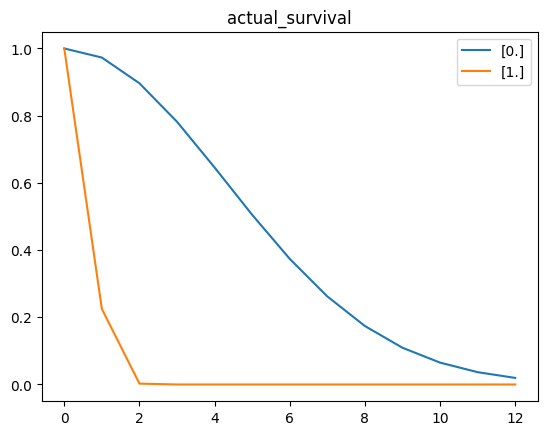

cens_calc: 0.0     
t_mean: 3.29     
t_max: 12.0
hazard rate 1 [11.9346  23.8692  35.80379]
hazard rate 0 [0.21859 0.43718 0.65577]
HR t-series = [54.59810604 54.59810604 54.59809079]


/tmp/ipykernel_283/2047446694.py:40: RuntimeWarning: invalid value encountered in divide
  HR_unique = hz_unique[1]/hz_unique[0]


In [6]:
OUTPUTS = "outputs"
ALPHA = 2
LAMBDA = "np.exp(-1.8 + 2*x_mat[:,0])"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# get unique x_mat
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
hz_unique = np.round(hz_mat[x_unique[1],:],5) 

HR_unique = hz_unique[1]/hz_unique[0]
# HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
print(f"hazard rate 1 {hz_unique[1][HR_times]}")
print(f"hazard rate 0 {hz_unique[0][HR_times]}")
print(f"HR t-series = {HR_unique[HR_times]}")

In [7]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 4

y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 46 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


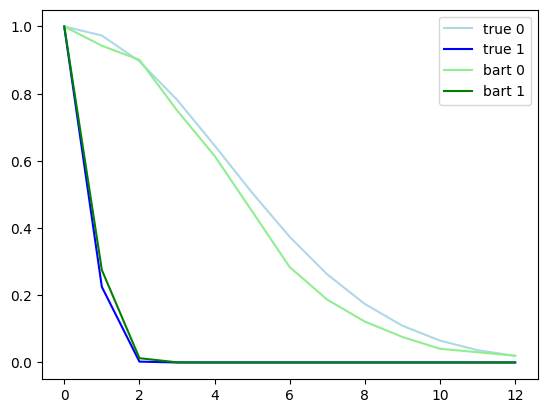

In [8]:
with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = [pmb.ContinuousSplitRule(), pmb.OneHotSplitRule()])
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_out)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]


plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
plt.legend()

In [9]:
# det the posterior predictive on all obs, no counterfactuals
post_pred = ssf.get_bart_test(x_mat,np.unique(b_tr_t))

In [10]:
# get the sv time predictions for metrics
with bart:
    pm.set_data({"x":pd.DataFrame(post_pred)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp_m = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])


Sampling: [f, y_pred]


In [11]:
# pp_m
# transform to survival
bart_sv_fx_m = ssf.get_sv_fx(pp_m, x_mat)
bart_sv_t_m = np.unique(b_tr_t)

In [12]:
TRAIN_CSV = "tmp_input.csv"
RBART_CSV = "tmp_output.csv"

In [41]:
# write csv
train.to_csv(TRAIN_CSV)

In [42]:
p1 = subprocess.Popen([
        "Rscript",
        "metrics_1_run.r",
        TRAIN_CSV,
        RBART_CSV
        ])
p1.wait()

Loading required package: nlme
Loading required package: nnet
Loading required package: survival


*****Calling gbart: type=2
*****Data:
data:n,p,np: 327, 2, 1100
y1,yn: 0.000000, 1.000000
x1,x[n*p]: 1.000000, 0.000000
xp1,xp[np*p]: 1.000000, 0.000000
*****Number of Trees: 50
*****Number of Cut Points: 10 ... 1
*****burn,nd,thin: 250,1250,10
*****Prior:beta,alpha,tau,nu,lambda,offset: 2,0.95,0.212132,3,1,-0.507761
*****Dirichlet:sparse,theta,omega,a,b,rho,augment: 0,0,1,0.5,1,2,0
*****printevery: 100

MCMC
done 0 (out of 1500)
done 100 (out of 1500)
done 200 (out of 1500)
done 300 (out of 1500)
done 400 (out of 1500)
done 500 (out of 1500)
done 600 (out of 1500)
done 700 (out of 1500)
done 800 (out of 1500)
done 900 (out of 1500)
done 1000 (out of 1500)
done 1100 (out of 1500)
done 1200 (out of 1500)
done 1300 (out of 1500)
done 1400 (out of 1500)
time: 2s
trcnt,tecnt: 125,125
*****In main of C++ for bart prediction
tc (threadcount): 8
number of bart draws: 1000
number of trees in bart sum: 50
number of x columns: 2
from x,np,p: 2, 22
***using parallel code


0

In [43]:
rbart = pd.read_csv(RBART_CSV)

In [47]:
tshape = np.unique(train["time"]).shape[0]
N = train.shape[0]
rb_surv_val = rbart["surv"].to_numpy().reshape((N,tshape))
rb_prob_val = rbart["prob"].to_numpy().reshape((N,tshape))
rb_mat = rbart["x1"][rbart["t"] == 1].to_numpy()
rb_time = train["time"].to_numpy()
rb_delta = train["status"].to_numpy()

C-INDEX

In [48]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [63]:
def prep_sv_curv(sv):
    sh1 = sv.shape[0]
    add = np.repeat(1, sh1, axis=0).reshape(sh1, 1)
    sv2 = np.hstack([add, sv])
    return sv2

def prep_uniq_times(times):
    t = np.unique(times)
    out = np.concatenate([[0],t])
    return out

def restr_mean_sv_t(sv, time, restr_t):
    if restr_t not in time:
        print("Restircted time not in set of unique times")
        return None
    sh1 = sv.shape[0]
    idx = np.where(time == restr_t)[0][0]
    # print(idx)
    time = time[0:idx]
    sv = sv[:,0:idx]
    out = np.trapz(sv, time, axis=1)

    return out.reshape(sh1,)
    

In [64]:
rb_sv1 = prep_sv_curv(rb_surv_val)
rb_t_unq = prep_uniq_times(rb_time)
rb_rmsvt = restr_mean_sv_t(rb_sv1, rb_t_unq, 12)

In [123]:
p_sv1 = prep_sv_curv(bart_sv_fx_m)
p_t_unq = bart_sv_t
p_rmsvt = restr_mean_sv_t(p_sv1, p_t_unq, 12)

In [124]:
concordance_index_censored(
    np.array(rb_delta, dtype="bool"), 
    rb_time, 
    -rb_rmsvt
    )

(0.7900763358778626, 2325, 45, 1560, 0)

In [125]:
prob1 = pp_m.posterior_predictive["mu"].mean(("draw", "chain")).values.reshape(100,11)
concordance_index_censored(
    np.array(rb_delta, dtype="bool"),
    rb_time,
    # -p_rmsvt
    prob1[:,0]
)

(0.7900763358778626, 2325, 45, 1560, 0)

Looks like the c-index is fine

# time-auc

In [122]:
# prob1
bart_sv_t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12.])

In [147]:
rb_prob_val[0]

array([0.74142078, 0.84795514, 0.9248191 , 0.92185985, 0.94965446,
       0.96437433, 0.95204839, 0.94731336, 0.94087335, 0.9716924 ,
       0.9716924 ])

In [151]:

# y_sk 
# prob1
# r
p_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=prob1[:,1:], times=bart_sv_t[1:11])
r_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=rb_prob_val[:,:10], times=bart_sv_t[1:11])
# bart_sv_t[1:12]

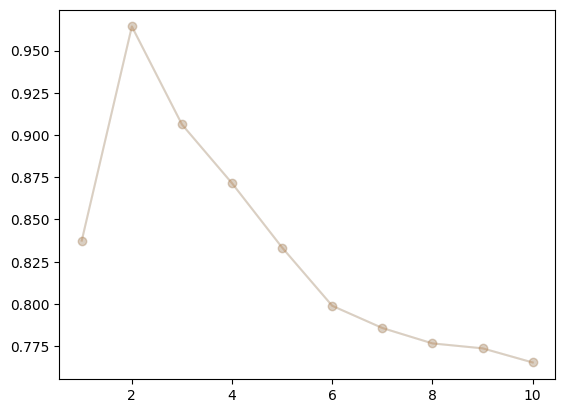

In [162]:
plt.plot(bart_sv_t[1:11], p_cda[0], marker="o", alpha=0.2)
plt.plot(bart_sv_t[1:11], r_cda[0], marker = "o", alpha=0.2)


# Integrated Brier score

In [171]:
p_ibs = integrated_brier_score(y_sk, y_sk, bart_sv_fx_m[:, 1:], bart_sv_t[1:11])
r_ibs = integrated_brier_score(y_sk, y_sk, rb_surv_val[:, 1:], bart_sv_t[1:11])
print(p_ibs, r_ibs)
# p_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=prob1[:,1:], times=bart_sv_t[1:11])

0.08670607784843094 0.0870573111240815
